In [1]:
%matplotlib inline
import cv2, os, ast, time 
from datetime import datetime
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from typing import List

import torch
import torchvision
from torchvision.ops import box_iou
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from sklearn.model_selection import train_test_split
from torchinfo import summary
from mAP import mean_average_precision 
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models import ResNet101_Weights

In [2]:
%cd ..
cwd = os.getcwd()
base_dir = 'h:\Python\ob'
train_csv = os.path.join(base_dir, "train.csv")
train_df = pd.read_csv(train_csv)
train_df["img_path"] = os.path.join(base_dir, "train_images") + "/video_" + train_df.video_id.astype(str) + "/" + train_df.video_frame.astype(str) + ".jpg"
train_df["annotations"] = train_df["annotations"].apply(eval)
train_df["a_count"] = train_df["annotations"].apply(len)
train_df = train_df.drop(columns=['video_id', 'sequence', 'video_frame', 'sequence_frame'])
train_df_positive = train_df[train_df['a_count'] != 0]
train_df_positive= train_df_positive.reset_index(drop=True)
print('shape of train data with annotations:', train_df_positive.shape)

train_df_ratio = (train_df_positive.set_index('image_id').explode('annotations').
                  apply(lambda row: pd.Series(row['annotations']), axis=1).reset_index())
train_df_ratio['aspect_ratio'] = train_df_ratio['height']/train_df_ratio['width']


train_df_p, val_df_p = train_test_split(train_df_positive, test_size=0.1, random_state=0)
print('shape of training data:', train_df_p.shape)
print('shape of validation data:', val_df_p.shape)
print('Min number of bboxs per image:', min(train_df_positive.a_count))
print('Max number of bboxs per image:', max(train_df_positive.a_count))
print('Max width of all bboxs:', max(train_df_ratio.width))
print('Max height of all bboxs:', max(train_df_ratio.height))
print('Min width of all bboxs:', min(train_df_ratio.width))
print('Min height of all bboxs:', min(train_df_ratio.height))

print('{:.2%} of all aspect ratios greater than 2'.
      format(train_df_ratio[train_df_ratio['aspect_ratio'] > 1.5].shape[0]/train_df_ratio.shape[0]))

print('{:.2%} of all aspect ratios less than 0.25'.
      format(train_df_ratio[train_df_ratio['aspect_ratio'] < 0.5].shape[0]/train_df_ratio.shape[0]))

h:\Python\ob\train_models
shape of train data with annotations: (4919, 4)
shape of training data: (4427, 4)
shape of validation data: (492, 4)
Min number of bboxs per image: 1
Max number of bboxs per image: 18
Max width of all bboxs: 243
Max height of all bboxs: 222
Min width of all bboxs: 17
Min height of all bboxs: 13
1.47% of all aspect ratios greater than 2
1.15% of all aspect ratios less than 0.25


In [3]:
class COTS_Dataset(torch.utils.data.Dataset):
    def __init__(self, df_img, df_bbox, original_size=(1280, 720), resize_size=(1280, 720)):
        self.df_img = df_img
        self.df_bbox = df_bbox
        self.orginal_size = original_size
        self.resize_size = resize_size
        
    def __getitem__(self, idx):
        # load images and masks
        row = self.df_img.iloc[idx]
        img = Image.open(row['img_path']).convert('RGB')
        if True: 
            img = np.array(img)/255.
        else:
            img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.
        data = self.df_bbox[self.df_bbox['image_id'] == row['image_id']]
        labels = ['cots'] * data.shape[0]
        data = data[['x','y','width','height']].values
        area = data[:, 2] * data[:, 3]
        data[:,[2]] += data[:,[0]]
        data[:,[3]] += data[:,[1]]
        boxes = data.astype(np.uint32).tolist() # convert to absolute coordinates
        # torch FRCNN expects ground truths as a dictionary of tensors
        iscrowd = torch.zeros((data.shape[0],), dtype=torch.int64)
        target = {}
        target["boxes"] = torch.Tensor(boxes).float()
        target["labels"] = torch.Tensor([1 for i in labels]).long()
        target["image_id"] = torch.Tensor([idx])
        target["area"] = torch.Tensor(area).float()
        target["iscrowd"] = iscrowd

        img = torch.tensor(img).permute(2,0,1)
        return img.to(device).float(), target
    
    def collate_fn(self, batch):
        return tuple(zip(*batch)) 

    def __len__(self):
        return self.df_img.shape[0]

In [4]:
train_ds = COTS_Dataset(train_df_p, train_df_ratio)
test_ds = COTS_Dataset(val_df_p, train_df_ratio)

train_loader = DataLoader(train_ds, batch_size=1, collate_fn=train_ds.collate_fn, drop_last=False)
test_loader = DataLoader(test_ds, batch_size=1, collate_fn=test_ds.collate_fn, drop_last=False)

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
'''
backbone = resnet_fpn_backbone('resnet101', weights=ResNet101_Weights.IMAGENET1K_V2, trainable_layers=5)
model = FasterRCNN(backbone, num_classes=2)
'''
model.load_state_dict(torch.load('./FasterRCNN/fasterrcnn_resnet50_fpn_free_last2_batch3_e12.bin'))
model.to(device)
model.eval()

from torchvision.ops import nms
def decode_output(output):
    'convert tensors to numpy arrays'
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array(['cots' for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.5)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\sl4n21/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [19]:
summary(model)

Layer (type:depth-idx)                                  Param #
FasterRCNN                                              --
├─GeneralizedRCNNTransform: 1-1                         --
├─BackboneWithFPN: 1-2                                  --
│    └─IntermediateLayerGetter: 2-1                     --
│    │    └─Conv2d: 3-1                                 (9,408)
│    │    └─FrozenBatchNorm2d: 3-2                      --
│    │    └─ReLU: 3-3                                   --
│    │    └─MaxPool2d: 3-4                              --
│    │    └─Sequential: 3-5                             (212,992)
│    │    └─Sequential: 3-6                             1,212,416
│    │    └─Sequential: 3-7                             7,077,888
│    │    └─Sequential: 3-8                             14,942,208
│    └─FeaturePyramidNetwork: 2-2                       --
│    │    └─ModuleList: 3-9                             984,064
│    │    └─ModuleList: 3-10                            2,360,320
│    

In [7]:
def calculate_score(preds: List[torch.Tensor], gts: List[torch.Tensor], iou_th: float) -> float:
    num_tp = 0
    num_fp = 0
    num_fn = 0
    for p, GT in zip(preds, gts):
        if len(p) and len(GT):
            gt = GT.clone()
            gt[:, 2] = gt[:, 0] + gt[:, 2]
            gt[:, 3] = gt[:, 1] + gt[:, 3]
            pp = p.clone()
            pp[:, 2] = pp[:, 0] + pp[:, 2]
            pp[:, 3] = pp[:, 1] + pp[:, 3]
            iou_matrix = box_iou(pp, gt)
            tp = len(torch.where(iou_matrix.max(0)[0] >= iou_th)[0])
            fp = len(p) - tp
            fn = len(torch.where(iou_matrix.max(0)[0] < iou_th)[0])
            num_tp += tp
            num_fp += fp
            num_fn += fn
        elif len(p) == 0 and len(GT):
            num_fn += len(GT)
        elif len(p) and len(GT) == 0:
            num_fp += len(p)
    score = 5 * num_tp / (5 * num_tp + 4 * num_fn + num_fp)
    return score

In [14]:
img_id = []
bbox = []
confidence = []
label = []
for ix, (image, targets) in enumerate(test_loader):
    outputs = model(image)[0]
    bbs, confs, labels = decode_output(outputs)
    bbox.append(bbs)
    confidence.append(confs)
    label.append(labels)
    img_id.append(targets[0]['image_id'].cpu().detach())

In [9]:
# mAP score on training data and test data
pred_boxes_map = []
true_boxes_map = []

for ix, (image, targets) in enumerate(train_loader):
    outputs = model(image)[0]
    bbs, confs, labels = decode_output(outputs)
    for i in range(len(bbs)): 
        a = [targets[0]['image_id'].cpu().detach().item(), 0, confs[0]] + bbs[i]
        pred_boxes_map.append(a)
        
    gt_bbs = targets[0]['boxes'].cpu().detach().numpy().astype(np.uint16).tolist()
    for j in range(len(gt_bbs)): 
        b = [targets[0]['image_id'].cpu().detach().item(), 0, 1] + gt_bbs[j]
        true_boxes_map.append(b)
        
mean_ap_train = mean_average_precision(pred_boxes_map, true_boxes_map, 
                                       iou_threshold=0.5, box_format="midpoint", num_classes=1)
print('mAP on training set is:', mean_ap_train)

pred_boxes_map = []
true_boxes_map = []

for ix, (image, targets) in enumerate(test_loader):
    outputs = model(image)[0]
    bbs, confs, labels = decode_output(outputs)
    for i in range(len(bbs)): 
        a = [targets[0]['image_id'].cpu().detach().item(), 0, confs[0]] + bbs[i]
        pred_boxes_map.append(a)
        
    gt_bbs = targets[0]['boxes'].cpu().detach().numpy().astype(np.uint16).tolist()
    for j in range(len(gt_bbs)): 
        b = [targets[0]['image_id'].cpu().detach().item(), 0, 1] + gt_bbs[j]
        true_boxes_map.append(b)
        
mean_ap_test = mean_average_precision(pred_boxes_map, true_boxes_map, 
                                      iou_threshold=0.5, box_format="midpoint", num_classes=1)
print('mAP on training set is:', mean_ap_test)

mAP on training set is: tensor(0.9105)
mAP on training set is: tensor(0.8837)


In [15]:
# F2 score on training data and test data
predictions = []
gts = []
infer_time_train = []

time_begin = time.time()
for ix, (image, targets) in enumerate(train_loader):
    t0 = time.time() 
    outputs = model(image)[0]
    infer_time_train.append(time.time() - t0)
    gts.append(targets[0]['boxes']) 
    predictions.append(outputs['boxes'].cpu().detach())

print('Inference Time Used: {:.2f} seconds'.format(time.time()- time_begin))
iou_ths = np.arange(0.3, 0.85, 0.05)
scores = [calculate_score(predictions, gts, iou_th) for iou_th in iou_ths]
print('Avg inference time for training set:', np.mean(infer_time_train))
print('Training average F2 score is {:.3f}'.format(np.mean(scores))) 

predictions = []
gts = []
infer_time_val = []

time_begin = time.time()
for ix, (image, targets) in enumerate(test_loader):
    t0 = time.time() 
    outputs = model(image)[0]
    infer_time_val.append(time.time() - t0)
    gts.append(targets[0]['boxes']) 
    predictions.append(outputs['boxes'].cpu().detach())
    
print('Inference Time Used: {:.2f} seconds'.format(time.time()- time_begin))
iou_ths = np.arange(0.3, 0.85, 0.05)
scores = [calculate_score(predictions, gts, iou_th) for iou_th in iou_ths]
print('Avg inference time for validation set:', np.mean(infer_time_val))
print('Test average F2 score is {:.3f}'.format(np.mean(scores)))

Inference Time Used: 707.98 seconds
Avg inference time for training set: 0.08980763160484974
Training average F2 score is 0.974
Inference Time Used: 77.18 seconds
Avg inference time for validation set: 0.0896464242198603
Test average F2 score is 0.962


In [11]:
def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    if bboxes == []:
        return []
    else:
        bboxes = np.array(bboxes)
        bboxes[:,[2]] += bboxes[:,[0]]
        bboxes[:,[3]] += bboxes[:,[1]]
        return bboxes.tolist()

train_df['bboxes'] = train_df.annotations.apply(get_bbox)

In [12]:
# F2 score on all data including negative images 
predictions = []
gts = []

time_begin = time.time()
for idx, row in train_df.iterrows():
    img = Image.open(row['img_path']).convert('RGB')
    img = np.array(img)/255.
    img = torch.tensor(img).permute(2,0,1)
    outputs = model((img.float().to(device),))[0]
    pred = outputs['boxes'].cpu().detach()
    if pred.size() == torch.Size([0, 4]):
        predictions.append(torch.tensor([]).cpu().detach())
    else:
        predictions.append(pred)
    gts.append(torch.tensor(row.bboxes))
    
print('Inference Time Used: {:.2f} seconds'.format(time.time()- time_begin))
iou_ths = np.arange(0.3, 0.85, 0.05)
scores = [calculate_score(predictions, gts, iou_th) for iou_th in iou_ths]
print('Test average F2 score is {:.3f}'.format(np.mean(scores)))


Inference Time Used: 4299.21 seconds
Test average F2 score is 0.939


number of ground truth boxes: 1
number of predicted boxes: 1
number of ground truth boxes: 9
number of predicted boxes: 9
number of ground truth boxes: 1
number of predicted boxes: 1
number of ground truth boxes: 5
number of predicted boxes: 5


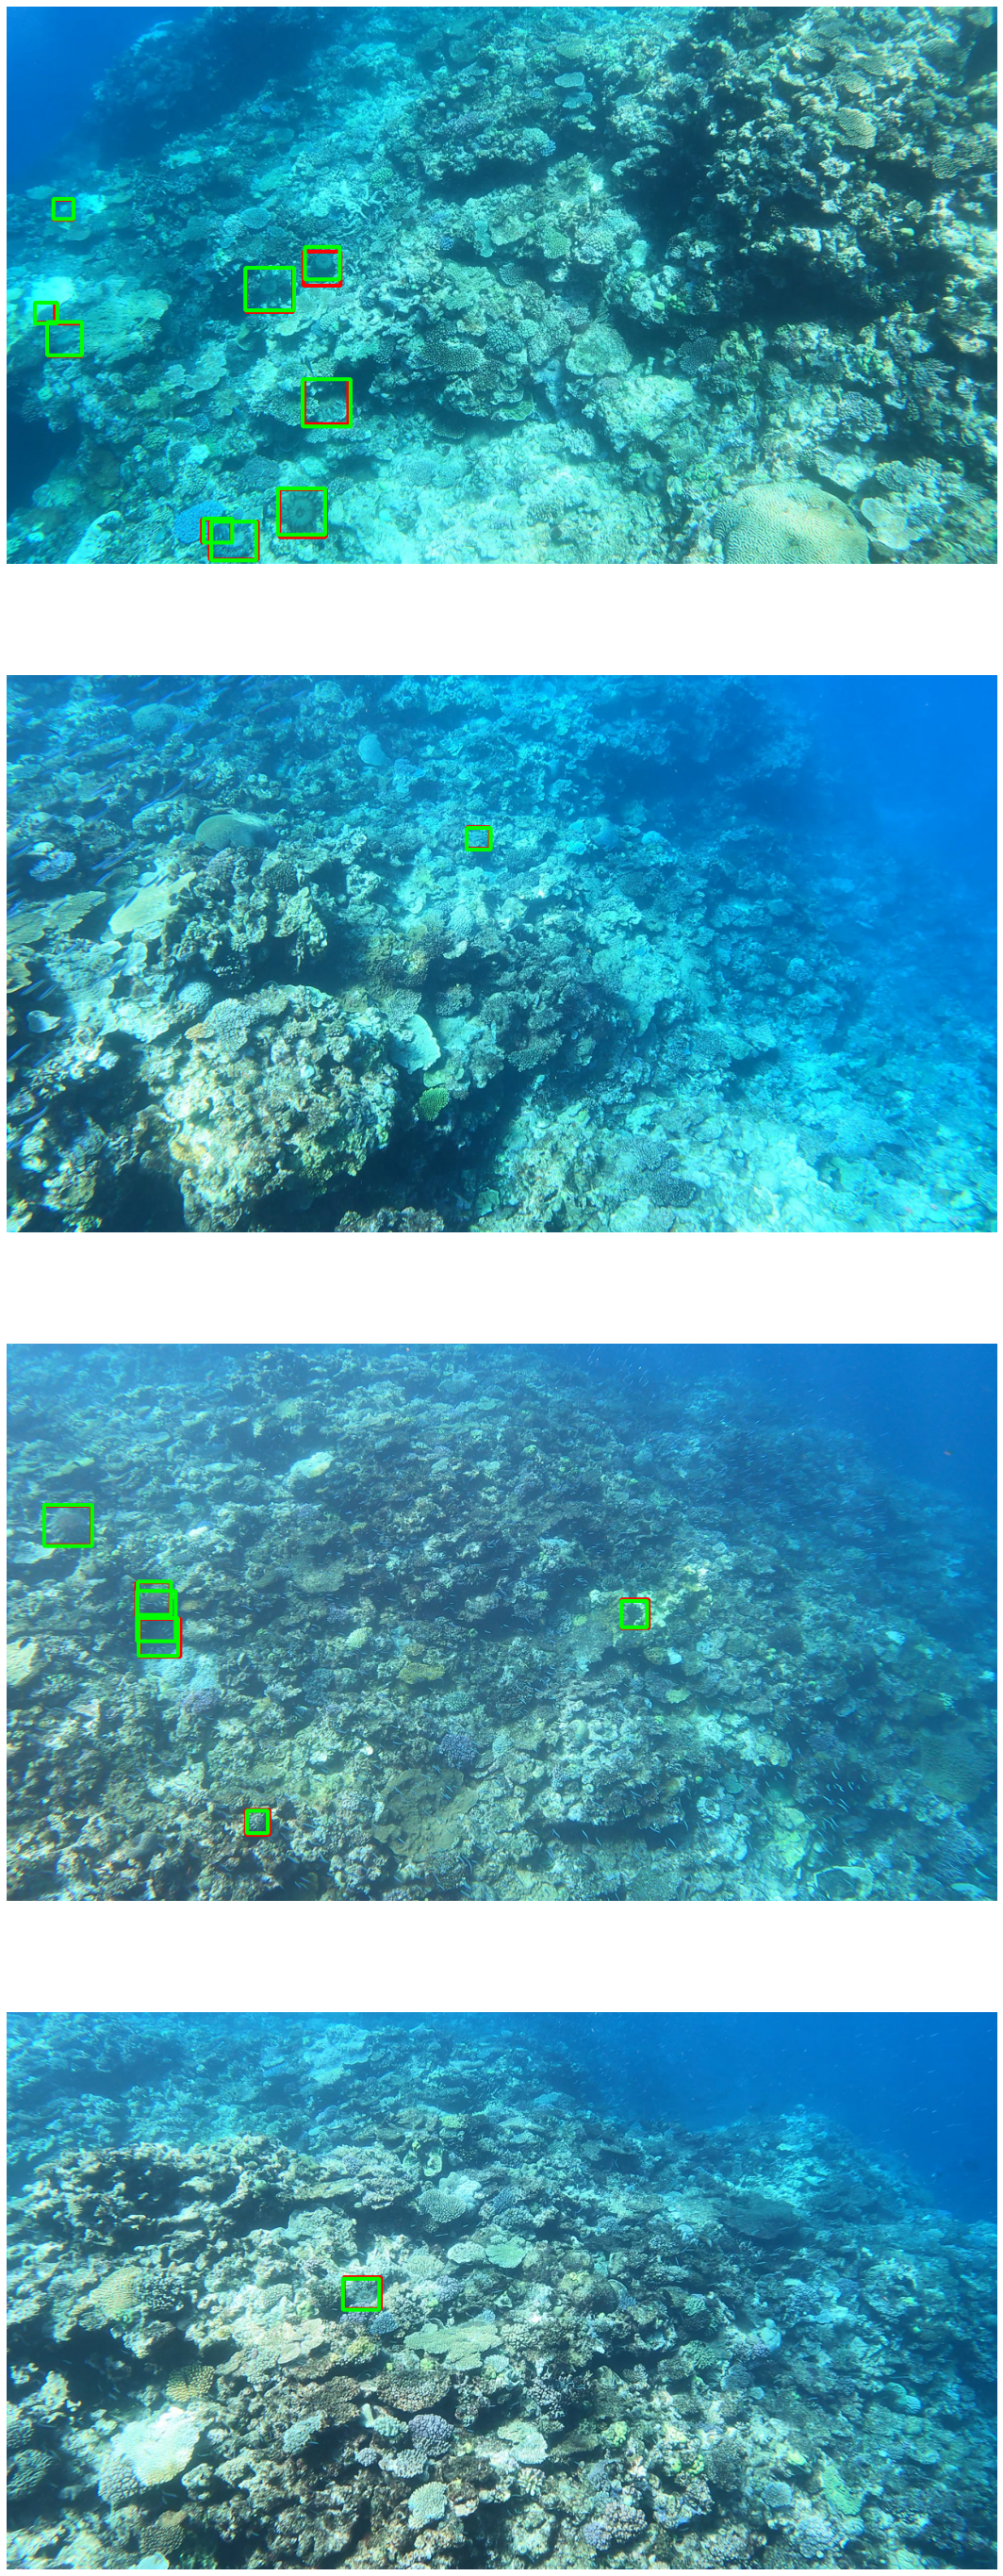

In [17]:
# test on images 
random_sample = np.random.randint(0, 491, size=4)

fig, ax = plt.subplots(4, 1, figsize=(100, 50))

for i in range(len(random_sample)):
    image, targets =  test_ds[random_sample[i-1]]
    sample = (image.permute(1,2,0).cpu().numpy()*255).astype(np.int32)
    boxes = targets['boxes'].cpu().numpy().astype(np.int32)
    
    pred_box = bbox[random_sample[i-1]]
    print('number of ground truth boxes:', len(boxes))
    print('number of predicted boxes:', len(boxes))
    # Red for ground truth
    for box in boxes:
        cv2.rectangle(sample,(box[0], box[1]),(box[2], box[3]),(255, 0, 0), 3)


    # Green for predictions
    for box in pred_box:
        cv2.rectangle(sample,(box[0], box[1]),(box[2], box[3]),(0, 255, 0), 3)
    ax[i-1].set_axis_off()
    ax[i-1].imshow(sample)
